In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import seaborn as sns 
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras import layers, models

2023-08-25 16:38:55.741551: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Read the CSV file named "train.csv" into a DataFrame called df
df = pd.read_csv("archive/train.csv")

# Display the first few rows of the DataFrame df
df_head = df.head()
print(df_head)

          ID   Class
0    377.jpg  MIDDLE
1  17814.jpg   YOUNG
2  21283.jpg  MIDDLE
3  16496.jpg   YOUNG
4   4487.jpg  MIDDLE


In [3]:
# Replace values in the 'Class' column with corresponding numeric values
class_mapping = {'YOUNG': 0, 'MIDDLE': 1, 'OLD': 2}
df['Class'].replace(class_mapping, inplace=True)

# Display the first three rows of the DataFrame to show the changes
df_head_3 = df.head(3)
print(df_head_3)


          ID  Class
0    377.jpg      1
1  17814.jpg      0
2  21283.jpg      1


In [4]:
def readImage(path,ch = 3, resize=(150,150)):
	di = tf.io.read_file(path)
	di = tf.image.decode_jpeg(di, channels=ch)
	di = tf.image.convert_image_dtype(di, dtype=tf.float32)
	di = tf.image.resize(di, resize)
	return di

In [5]:
# function to load the data that includes images and respective labels
def load_data(image_path, label):
    img = readImage(image_path, 3, (150,150))
    return (img, label)

In [6]:
# built the list of image paths and list of respective responses of the images
PATH = "archive/Train"
image_paths = []
for path in os.listdir(PATH):
    image_paths.append(PATH+"/"+path)
print(len(image_paths))

response_list = []

for i in image_paths:
    _,tail = os.path.split(i)
    response = df.loc[df['ID'] == tail]['Class'].values[0]
    response_list.append(response)
print(len(response_list))


19906
19906


In [7]:
# split the dataset into train and test dataset
train_size = int(0.9*(len(image_paths)))
print(train_size)
test_size = int(0.1*(len(image_paths)))

train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], response_list[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[test_size:], response_list[test_size:]))

17915


2023-08-25 16:40:16.862652: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
train_set = (train_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [9]:
test_set = (test_set
    .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [10]:


model = models.Sequential([
    layers.Conv2D(filters=30, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3), padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])


In [11]:
# view the summary of the cnn model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 30)      840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        17344     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 87616)             0         
                                                                 
 dense (Dense)               (None, 64)                5

In [12]:
# compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [13]:
# fit the model
history_cnn = model.fit(train_set, epochs=10, validation_data=test_set, batch_size=64)

Epoch 1/10


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
280/280 [==============================] - ETA: 0s - loss: 0.8521 - accuracy: 0.6191WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd3b367a3b0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach th

In [15]:
# Save the trained model
model.save('trained_cnn_model.h5')

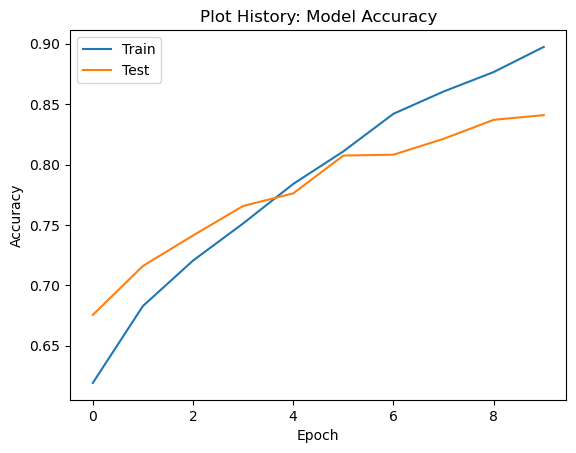

In [16]:
# plot the accuracy and loss
plt.plot(history_cnn.history['accuracy'], label='train')
plt.plot(history_cnn.history['val_accuracy'], label='test')
plt.title('Plot History: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

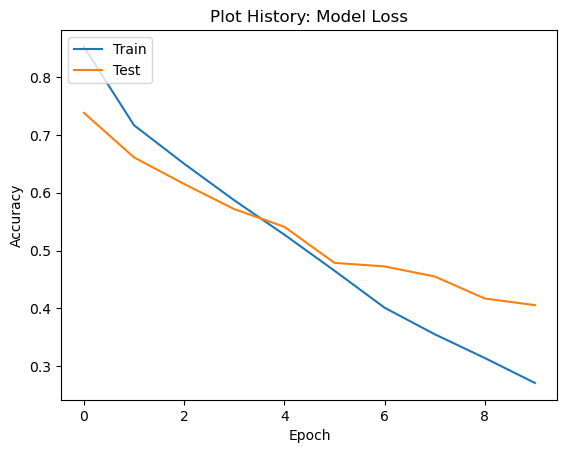

In [28]:
# plot the accuracy and loss
plt.plot(history_cnn.history['loss'], label='train')
plt.plot(history_cnn.history['val_loss'], label='test')
plt.title('Plot History: Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [31]:
model.evaluate(train_set)

280/280 [==============================] - 146s 520ms/step - loss: 0.3478 - accuracy: 0.8585


[0.34778058528900146, 0.8584984540939331]

In [32]:
# test accuracy
model.evaluate(test_set)

280/280 [==============================] - 135s 481ms/step - loss: 0.4057 - accuracy: 0.8409


[0.40569624304771423, 0.8409243226051331]

In [82]:
# Load the saved model
loaded_model = tf.keras.models.load_model('trained_cnn_model.h5')

In [83]:
test_pred = loaded_model.predict(test_set)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
280/280 [==============================] - 138s 490ms/step


In [84]:
y_labels = [np.argmax(item) for item in test_pred]
print("Test Predictions response sample:",y_labels[:10])

test_response = response_list[test_size:]
print("Test True response sample:", test_response[:10])

Test Predictions response sample: [0, 1, 0, 1, 0, 1, 0, 1, 1, 2]
Test True response sample: [0, 1, 0, 2, 0, 1, 0, 1, 1, 2]


In [85]:
class_names = ['YOUNG','MIDDLE','OLD']
# funtion to plot confusio matrix to check the accuracy of each class value
def plot_confusion_matrix(y_true, test_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, test_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    # Print classification report
    print(classification_report(y_true, test_pred))

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
# plot

Confusion matrix, without normalization
[[4819  649  153]
 [1125 8897  644]
 [  83  196 1350]]
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      5621
           1       0.91      0.83      0.87     10666
           2       0.63      0.83      0.72      1629

    accuracy                           0.84     17916
   macro avg       0.78      0.84      0.80     17916
weighted avg       0.85      0.84      0.84     17916



<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

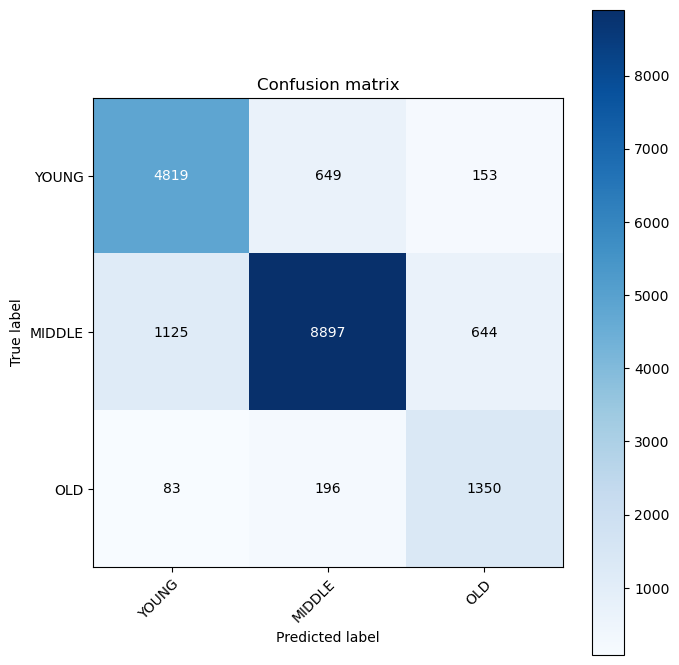

In [86]:
# plotting confusion matrix without normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names,
                      title='Confusion matrix')

In [49]:
pretrained_model = tf.keras.applications.Xception(
        weights='imagenet',
        include_top=False ,
        input_shape=[150, 150, 3]
    )
pretrained_model.trainable = False

model = tf.keras.Sequential([
       pretrained_model, tf.keras.layers.GlobalAveragePooling2D(), tf.keras.layers.Dense(3, activation='softmax')
    ])

In [51]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history_pre_trained = model.fit(train_set, epochs=10, validation_data=test_set,batch_size=64)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
280/280 [==============================] - ETA: 0s - loss: 0.7133 - accuracy: 0.6962 WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fd3b39bb9e0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) a

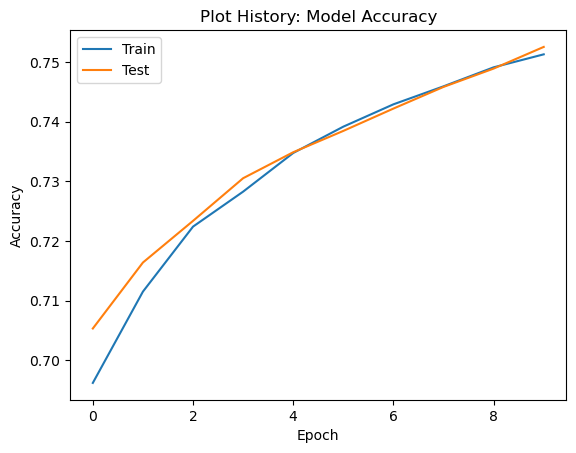

In [52]:
# plot the accuracy and loss
plt.plot(history_pre_trained.history['accuracy'], label='train')
plt.plot(history_pre_trained.history['val_accuracy'], label='test')
plt.title('Plot History: Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

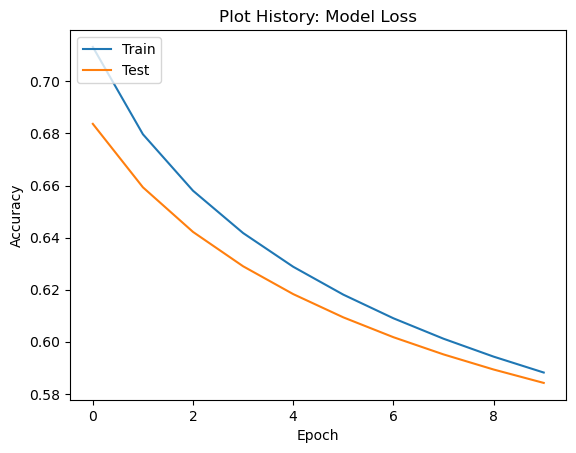

In [53]:
# plot the accuracy and loss
plt.plot(history_pre_trained.history['loss'], label='train')
plt.plot(history_pre_trained.history['val_loss'], label='test')
plt.title('Plot History: Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
pre_trained_pred = model.predict(test_set)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
280/280 [==============================] - 3645s 13s/step


In [56]:
y_labels = [np.argmax(item) for item in pre_trained_pred]
print("Test Predictions response sample:",y_labels[:10])

test_response = response_list[test_size:]
print("Test True response sample:", test_response[:10])

Test Predictions response sample: [1, 1, 1, 1, 1, 1, 0, 1, 0, 1]
Test True response sample: [0, 1, 0, 2, 0, 1, 0, 1, 1, 2]


In [78]:
class_names = ['YOUNG','MIDDLE','OLD']
# funtion to plot confusio matrix to check the accuracy of each class value
def plot_confusion_matrix(y_true, pre_trained_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, pre_trained_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    # Print classification report
    print(classification_report(y_true, pre_trained_pred))

    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)
# plot

Confusion matrix, without normalization
[[3840  775  131]
 [2105 8725 1099]
 [  82  242  917]]
              precision    recall  f1-score   support

           0       0.64      0.81      0.71      4746
           1       0.90      0.73      0.81     11929
           2       0.43      0.74      0.54      1241

    accuracy                           0.75     17916
   macro avg       0.65      0.76      0.69     17916
weighted avg       0.79      0.75      0.76     17916



<AxesSubplot:title={'center':'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

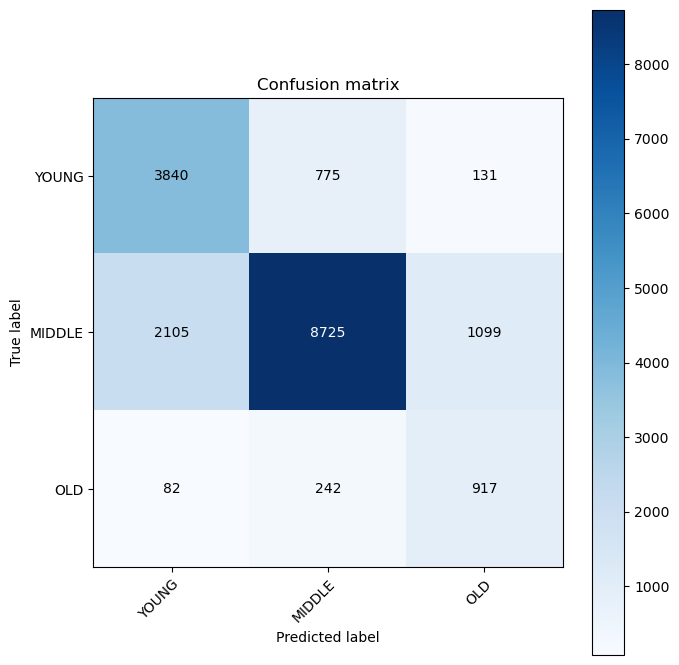

In [79]:
# plotting confusion matrix without normalization
plot_confusion_matrix(y_labels, test_response, classes=class_names,
                      title='Confusion matrix')